# Question 1

Considere uma rede deep learning convolutiva (treinada) aplicada à lassificação de padrões em imagens. A base de dados considerada é a CIFAR-10 (pesquise). A referida base de dados consiste de 60 mil imagens coloridas de 32x32 pixels, com 50 mil para treino e 10 mil para teste. As imagens estão divididas em 10 classes, a saber: avião, navio, caminhão, automóvel, sapo, pássaro, cachorro, gato, cavalo e cervo. Cada imagem possui apenas um dos objetos da classe de interesse, podendo estar parcialmente obstruído por outros objetos que não pertençam a esse conjunto. Apresente o desempenho da rede no processo de classificação usando uma matriz de confusão.

In [32]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Load the CIFAR-10 dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


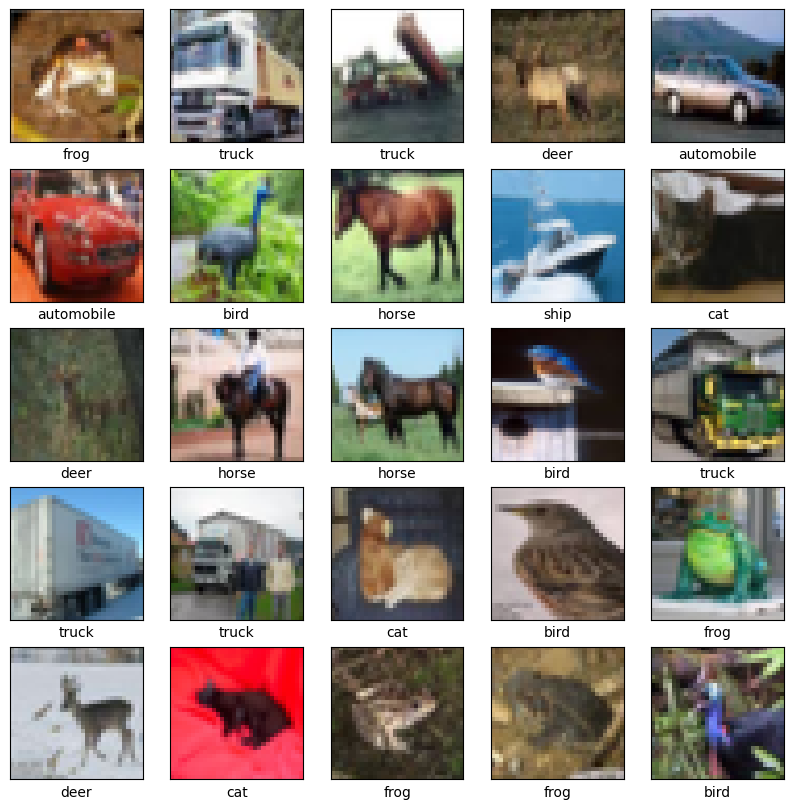

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize a few examples from the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])
plt.show()


In [6]:
x_train.dtype

dtype('uint8')

In [7]:
x_test.dtype

dtype('uint8')

## Raw Model

### Preprocess the data

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [9]:
x_train /= 255.0
x_test /= 255.0

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Define the model architecture

In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


### Compile the model

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

###  Callbacks

In [13]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Train the model

In [14]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=50,
                    batch_size=64,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
782/782 [==============================] - 26s 15ms/step - loss: 1.6084 - accuracy: 0.4466 - val_loss: 1.0501 - val_accuracy: 0.6209
Epoch 2/50
782/782 [==============================] - 10s 13ms/step - loss: 1.0456 - accuracy: 0.6324 - val_loss: 0.8894 - val_accuracy: 0.6870
Epoch 3/50
782/782 [==============================] - 10s 13ms/step - loss: 0.8752 - accuracy: 0.6929 - val_loss: 0.8007 - val_accuracy: 0.7172
Epoch 4/50
782/782 [==============================] - 11s 15ms/step - loss: 0.7670 - accuracy: 0.7355 - val_loss: 0.7843 - val_accuracy: 0.7280
Epoch 5/50
782/782 [==============================] - 11s 14ms/step - loss: 0.6856 - accuracy: 0.7649 - val_loss: 0.6511 - val_accuracy: 0.7795
Epoch 6/50
782/782 [==============================] - 10s 13ms/step - loss: 0.6381 - accuracy: 0.7794 - val_loss: 0.6338 - val_accuracy: 0.7814
Epoch 7/50
782/782 [==============================] - 10s 13ms/step - loss: 0.5923 - accuracy: 0.7973 - val_loss: 0.6244 - val_accuracy:

### Evaluate the model on the test set

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.4285 - accuracy: 0.8651 - 1s/epoch - 5ms/step

Test accuracy: 0.8651000261306763


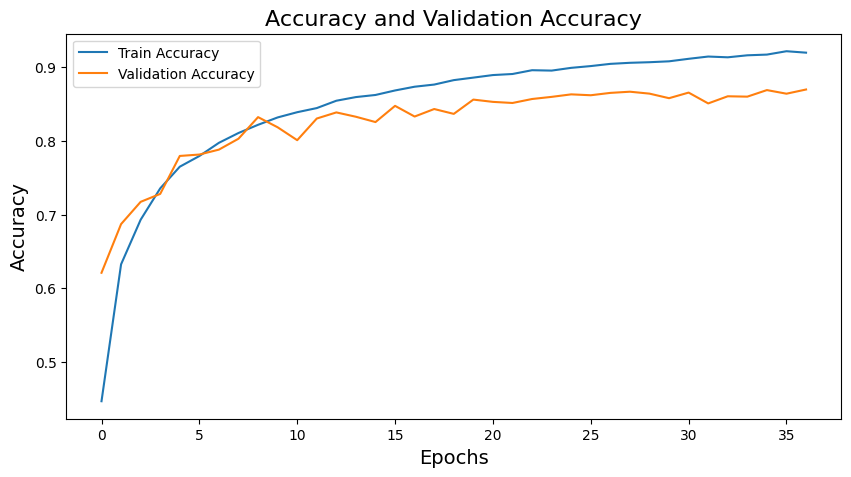

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy and Validation Accuracy', fontsize=16)
plt.legend()
plt.show()

### Make predictions on the test set

In [17]:
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


### Convert predictions from one-hot encoding to class labels

In [18]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

### Create a confusion matrix

In [19]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

### Print the confusion matrix

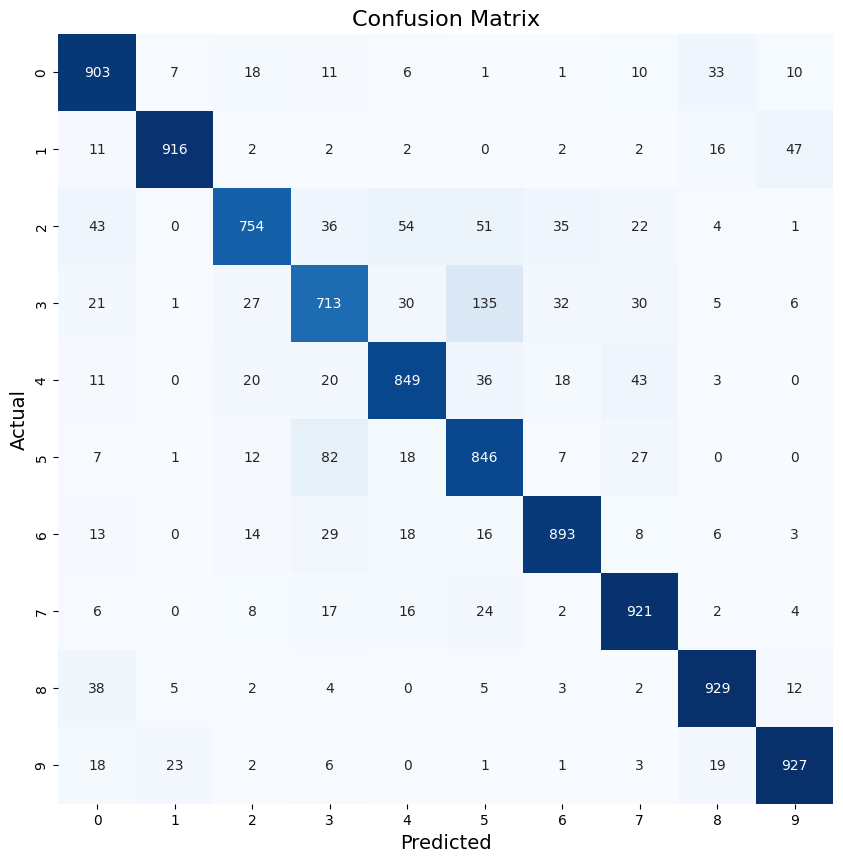

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [21]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Assim, percebe-se que as classes em que rede mais se cofundiu foi gato e cachorro.

## Transfer Learning from DenseNet201

### Define the model architecture

In [33]:
# instantiate the model
vgg16 = VGG16(
      include_top=False,
      weights="imagenet",
      input_shape=(32, 32, 3),
)

vgg16.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [42]:
# Congela os pesos das camadas do modelo base
for layer in vgg16.layers:
    layer.trainable = False

# Adiciona as camadas personalizadas ao modelo
x = Flatten()(vgg16.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

# Cria o novo modelo com as camadas personalizadas
model = Model(inputs=vgg16.input, outputs=output)

# Visualiza a arquitetura do modelo
model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

### Compile the model

In [43]:
# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Callbacks

In [44]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Train the model

In [45]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=50,
                    batch_size=64,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
782/782 [==============================] - 14s 16ms/step - loss: 1.5747 - accuracy: 0.4608 - val_loss: 1.3233 - val_accuracy: 0.5399
Epoch 2/50
782/782 [==============================] - 11s 15ms/step - loss: 1.3370 - accuracy: 0.5360 - val_loss: 1.2370 - val_accuracy: 0.5655
Epoch 3/50
782/782 [==============================] - 11s 14ms/step - loss: 1.2884 - accuracy: 0.5533 - val_loss: 1.2295 - val_accuracy: 0.5647
Epoch 4/50
782/782 [==============================] - 12s 15ms/step - loss: 1.2678 - accuracy: 0.5615 - val_loss: 1.2119 - val_accuracy: 0.5749
Epoch 5/50
782/782 [==============================] - 11s 14ms/step - loss: 1.2522 - accuracy: 0.5679 - val_loss: 1.2001 - val_accuracy: 0.5813
Epoch 6/50
782/782 [==============================] - 11s 14ms/step - loss: 1.2364 - accuracy: 0.5727 - val_loss: 1.2037 - val_accuracy: 0.5799
Epoch 7/50
782/782 [==============================] - 12s 16ms/step - loss: 1.2253 - accuracy: 0.5764 - val_loss: 1.1848 - val_accuracy:

### Evaluate the model on test set

In [46]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 3s - loss: 1.1305 - accuracy: 0.6066 - 3s/epoch - 9ms/step

Test accuracy: 0.6065999865531921


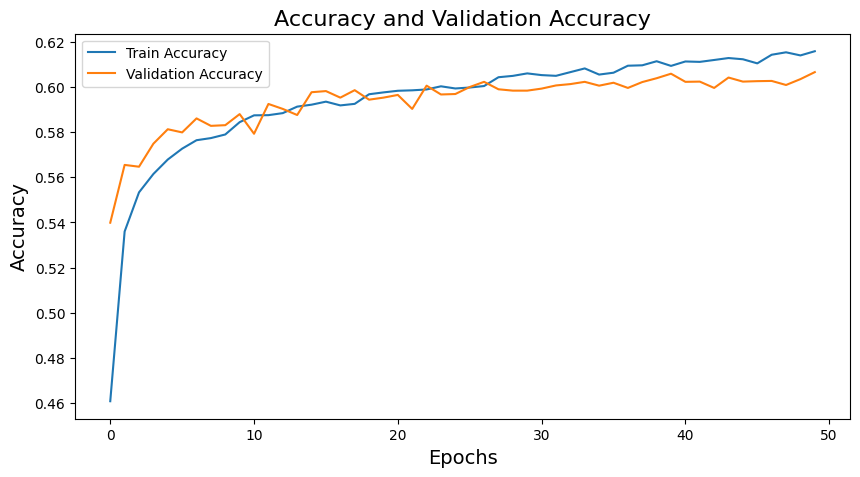

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy and Validation Accuracy', fontsize=16)
plt.legend()
plt.show()

### Make predictions on the test set

In [48]:
y_pred = model.predict(x_test)

313/313 [==============================] - 2s 7ms/step


### Convert predictions from one-hot encoding to class labels

In [49]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

### Print confusion matrix

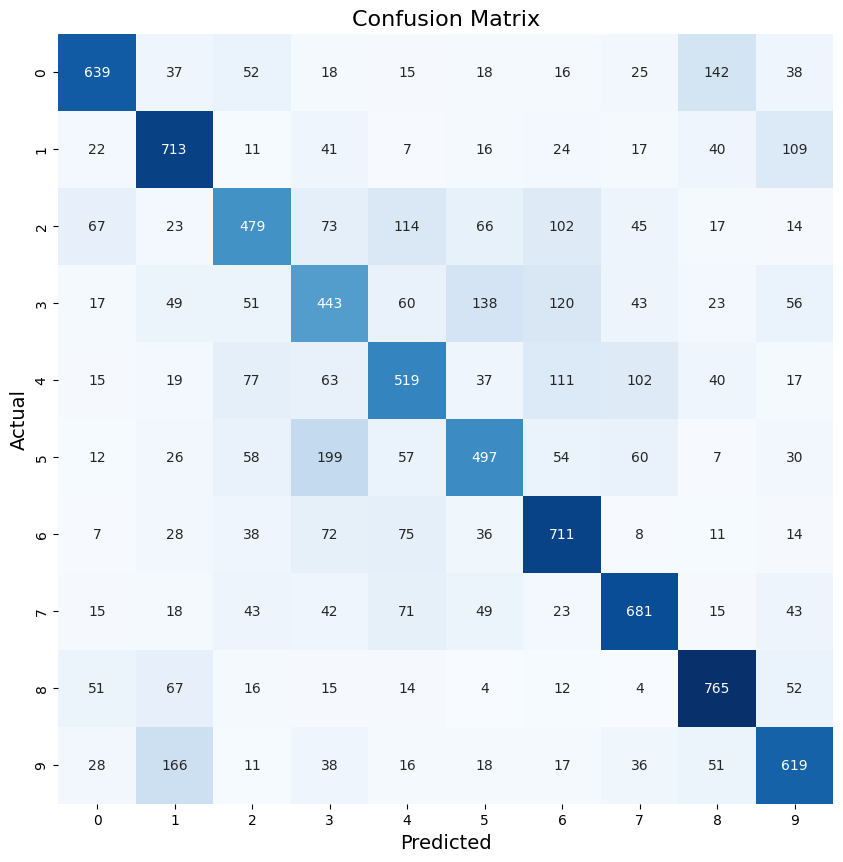

In [50]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [51]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Com isso, é possível observar que o modelo utilizando o transfer learning a partir da rede VGG16 obteve um desempenho pior do que o modelo treinado do zero anteriormente. Por exemplo, ele se confundiu entre as classes carro e avião, cachorro e gato, entre outros. Contudo, esse tende a ser um caso bem isolado e, de forma geral, a técnica de transfer learning apresenta resultados superiores em relação a modelos treinados do zero.